# Imports

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Hyperparameters

In [ ]:
BATCH_SIZE = 128
EPOCHS = 15
LR = 3e-4
IMG_SIZE = 28
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset Setup

In [ ]:
transform = transforms.Compose([
transforms.Resize((IMG_SIZE, IMG_SIZE)),
transforms.ToTensor(),
])
trainset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
testset = datasets.FashionMNIST(root='./data', train=False, download=True, transform=transform)
trainloader = DataLoader(trainset, batch_size=BATCH_SIZE, shuffle=True)
testloader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)


NUM_CLASSES = 10

100%|██████████| 26.4M/26.4M [00:02<00:00, 12.5MB/s]
100%|██████████| 29.5k/29.5k [00:00<00:00, 211kB/s]
100%|██████████| 4.42M/4.42M [00:01<00:00, 3.89MB/s]
100%|██████████| 5.15k/5.15k [00:00<00:00, 26.8MB/s]


# CNN Backbone for Hybrid Model

In [ ]:
class SmallCNN(nn.Module):
  def __init__(self,in_ch=1,out_ch=128):
    super().__init__()
    self.features=nn.Sequential(
        nn.Conv2d(in_ch,32,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(32,64,3,padding=1),
        nn.ReLU(),
        nn.MaxPool2d(2),
        nn.Conv2d(64,out_ch,3,padding=1),
        nn.ReLU()
    )

  def forward(self,x):
    return self.features(x)

# ViT Components

In [ ]:
class MultiHeadSelfAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads
        self.qkv = nn.Linear(embed_dim, embed_dim * 3)
        self.out = nn.Linear(embed_dim, embed_dim)

    def forward(self, x):
        B, N, D = x.shape
        qkv = self.qkv(x).reshape(B, N, 3, self.num_heads, self.head_dim).permute(2, 0, 3, 1, 4)
        q, k, v = qkv[0], qkv[1], qkv[2]
        attn = (q @ k.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn = attn.softmax(dim=-1)
        out = (attn @ v).transpose(1, 2).reshape(B, N, D)
        return self.out(out)


class TransformerEncoderBlock(nn.Module):
    def __init__(self, embed_dim=256, num_heads=8, mlp_ratio=4.0):
        super().__init__()
        self.norm1 = nn.LayerNorm(embed_dim)
        self.attn = MultiHeadSelfAttention(embed_dim, num_heads)
        self.norm2 = nn.LayerNorm(embed_dim)
        self.mlp = nn.Sequential(
            nn.Linear(embed_dim, int(embed_dim * mlp_ratio)),
            nn.GELU(),
            nn.Linear(int(embed_dim * mlp_ratio), embed_dim)
        )

    def forward(self, x):
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x


class PatchEmbed(nn.Module):
    def __init__(self, img_size=28, patch_size=4, in_ch=1, embed_dim=256):
        super().__init__()
        self.n_patches = (img_size // patch_size) ** 2
        self.proj = nn.Conv2d(in_ch, embed_dim, kernel_size=patch_size, stride=patch_size)
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, self.n_patches + 1, embed_dim))

    def forward(self, x):
        B = x.shape[0]
        x = self.proj(x).flatten(2).transpose(1, 2)
        cls_tokens = self.cls_token.expand(B, -1, -1)
        x = torch.cat((cls_tokens, x), dim=1)
        return x + self.pos_embed


# Model Variants

In [ ]:
class ViTOnly(nn.Module):
  def __init__(self,img_size=28,patch_size=4,in_ch=1,embed_dim=256,depth=4,num_heads=8):
    super().__init__()
    self.patch_embed=PatchEmbed(img_size,patch_size,in_ch,embed_dim)
    self.encoder=nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)])
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,NUM_CLASSES)

  def forward(self,x):
    x=self.patch_embed(x)
    x=self.encoder(x)
    x=self.norm(x[:,0])
    return self.head(x)

In [ ]:
class CNNOnly(nn.Module):
  def __init__(self):
    super().__init__()
    self.cnn=SmallCNN()
    self.classifier=nn.Sequential(
        nn.AdaptiveAvgPool2d(1),
        nn.Flatten(),
        nn.Linear(128,NUM_CLASSES)
    )

  def forward(self,x):
    x=self.cnn(x)
    return self.classifier(x)

In [ ]:
class HybridCNNViT(nn.Module):
  def __init__(self,embed_dim=256,num_heads=8,depth=4):
    super().__init__()
    self.cnn=SmallCNN(out_ch=embed_dim)
    self.flatten_proj=nn.Linear(embed_dim,embed_dim)
    self.cls_token=nn.Parameter(torch.zeros(1,1,embed_dim))
    self.pos_embed=nn.Parameter(torch.zeros(1,7*7+1,embed_dim))
    self.encoder=nn.Sequential(*[TransformerEncoderBlock(embed_dim, num_heads) for _ in range(depth)])
    self.norm=nn.LayerNorm(embed_dim)
    self.head=nn.Linear(embed_dim,NUM_CLASSES)

  def forward(self,x):
    feat=self.cnn(x)
    B, C, H, W = feat.shape
    x=feat.flatten(2).transpose(1,2)
    cls_token=self.cls_token.expand(B,-1,-1)
    x=torch.cat((cls_token,x),dim=1)
    x=x+self.pos_embed
    x=self.encoder(x)
    x=self.norm(x[:,0])
    return self.head(x)

# Training Loop

In [ ]:
def train_model(model, optimizer, criterion, trainloader, testloader, name="Model"):
    print(f"\nTraining {name}...")
    train_accs, test_accs = [], []
    for epoch in range(EPOCHS):
        model.train()
        correct, total = 0, 0
        for x, y in trainloader:
            x, y = x.to(DEVICE), y.to(DEVICE)
            optimizer.zero_grad()
            out = model(x)
            loss = criterion(out, y)
            loss.backward()
            optimizer.step()
            correct += (out.argmax(1) == y).sum().item()
            total += y.size(0)
        train_acc = correct / total

        model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in testloader:
                x, y = x.to(DEVICE), y.to(DEVICE)
                out = model(x)
                correct += (out.argmax(1) == y).sum().item()
                total += y.size(0)
        test_acc = correct / total

        train_accs.append(train_acc)
        test_accs.append(test_acc)
        print(f"Epoch {epoch+1}/{EPOCHS} | Train: {train_acc:.4f} | Test: {test_acc:.4f}")
    return train_accs, test_accs


# Model Comparison

In [ ]:
criterion=nn.CrossEntropyLoss()

cnn_model=CNNOnly().to(DEVICE)
cnn_opt=torch.optim.Adam(cnn_model.parameters(),lr=LR)
cnn_train,cnn_test=train_model(cnn_model, cnn_opt, criterion, trainloader, testloader, "CNN Only")





Training CNN Only...
Epoch 1/15 | Train: 0.5544 | Test: 0.6963
Epoch 2/15 | Train: 0.7159 | Test: 0.7289
Epoch 3/15 | Train: 0.7387 | Test: 0.7317
Epoch 4/15 | Train: 0.7511 | Test: 0.7484
Epoch 5/15 | Train: 0.7663 | Test: 0.7668
Epoch 6/15 | Train: 0.7741 | Test: 0.7782
Epoch 7/15 | Train: 0.7828 | Test: 0.7812
Epoch 8/15 | Train: 0.7912 | Test: 0.7924
Epoch 9/15 | Train: 0.7978 | Test: 0.7990
Epoch 10/15 | Train: 0.8040 | Test: 0.7986
Epoch 11/15 | Train: 0.8117 | Test: 0.8074
Epoch 12/15 | Train: 0.8161 | Test: 0.8162
Epoch 13/15 | Train: 0.8216 | Test: 0.8201
Epoch 14/15 | Train: 0.8252 | Test: 0.8162
Epoch 15/15 | Train: 0.8295 | Test: 0.8274


In [ ]:
vit_model = ViTOnly().to(DEVICE)
vit_opt = torch.optim.Adam(vit_model.parameters(), lr=LR)
vit_train, vit_test = train_model(vit_model, vit_opt, criterion, trainloader, testloader, "ViT Only")





Training ViT Only...
Epoch 1/15 | Train: 0.6817 | Test: 0.7885
Epoch 2/15 | Train: 0.8269 | Test: 0.8148
Epoch 3/15 | Train: 0.8471 | Test: 0.8392
Epoch 4/15 | Train: 0.8587 | Test: 0.8438
Epoch 5/15 | Train: 0.8634 | Test: 0.8556
Epoch 6/15 | Train: 0.8714 | Test: 0.8533
Epoch 7/15 | Train: 0.8777 | Test: 0.8576
Epoch 8/15 | Train: 0.8831 | Test: 0.8689
Epoch 9/15 | Train: 0.8865 | Test: 0.8706
Epoch 10/15 | Train: 0.8927 | Test: 0.8730
Epoch 11/15 | Train: 0.8974 | Test: 0.8688
Epoch 12/15 | Train: 0.9037 | Test: 0.8773
Epoch 13/15 | Train: 0.9073 | Test: 0.8784
Epoch 14/15 | Train: 0.9116 | Test: 0.8693
Epoch 15/15 | Train: 0.9169 | Test: 0.8787


In [ ]:
hybrid_model = HybridCNNViT().to(DEVICE)
hybrid_opt = torch.optim.Adam(hybrid_model.parameters(), lr=LR)
hybrid_train, hybrid_test = train_model(hybrid_model, hybrid_opt, criterion, trainloader, testloader, "Hybrid CNN+ViT")


Training Hybrid CNN+ViT...
Epoch 1/15 | Train: 0.7492 | Test: 0.8387
Epoch 2/15 | Train: 0.8676 | Test: 0.8631
Epoch 3/15 | Train: 0.8871 | Test: 0.8869
Epoch 4/15 | Train: 0.8973 | Test: 0.8963
Epoch 5/15 | Train: 0.9078 | Test: 0.8956
Epoch 6/15 | Train: 0.9130 | Test: 0.8954
Epoch 7/15 | Train: 0.9187 | Test: 0.8975
Epoch 8/15 | Train: 0.9228 | Test: 0.9031
Epoch 9/15 | Train: 0.9274 | Test: 0.9096
Epoch 10/15 | Train: 0.9317 | Test: 0.9103
Epoch 11/15 | Train: 0.9349 | Test: 0.9068
Epoch 12/15 | Train: 0.9387 | Test: 0.9093
Epoch 13/15 | Train: 0.9410 | Test: 0.9115
Epoch 14/15 | Train: 0.9446 | Test: 0.9061
Epoch 15/15 | Train: 0.9480 | Test: 0.9125


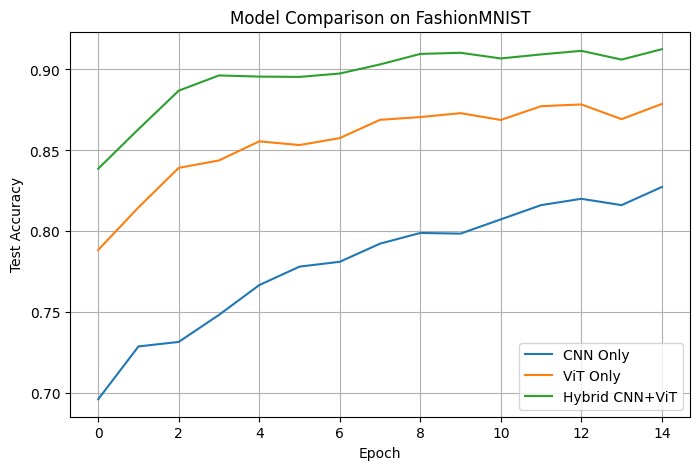

In [ ]:
plt.figure(figsize=(8,5))
plt.plot(cnn_test, label='CNN Only')
plt.plot(vit_test, label='ViT Only')
plt.plot(hybrid_test, label='Hybrid CNN+ViT')
plt.title('Model Comparison on FashionMNIST')
plt.xlabel('Epoch')
plt.ylabel('Test Accuracy')
plt.legend()
plt.grid()
plt.show()